In [ ]:
pip install opencv-python

In [ ]:
# Import the necessary libraries

import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Lambda, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

print ('All the required libraries have been imported')

All the required libraries have been imported


Number of benign images: 2376
Number of malignant images: 1440


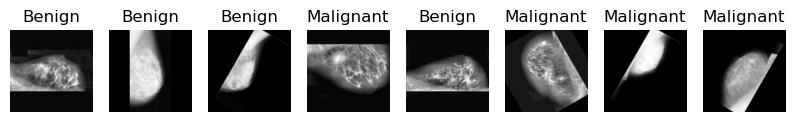

In [ ]:
# DATA PREPROCESSING
# The dataset (images) are preprocessed by setting the paths to the dataset, resizing, normalising and splitting them into train and test dataset.


# Set the paths to the dataset that is the benign and malignant images since they are in different folders.
benign_path = r"C:\Users\kenny\Desktop\tayo\Gabriel uk\MIAS Dataset\Benign Masses" # the benign path
malignant_path = r"C:\Users\kenny\Desktop\tayo\Gabriel uk\MIAS Dataset\Malignant Masses" # the malignant path

# The images and labels are held in an empty list thus an empty list is initialised
images = []
labels = []


# A function 'load images from folder" is created to load load images from a directory with reduced size
def load_images_from_folder(folder, label):
    count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # reducing image size from 227*227
            img = img / 255.0  # images are Normalised
            images.append(img)
            labels.append(label)
            count += 1
    return count

# Reload the images after reducing the size
images = []
labels = []

# Load and count the number of benign images
benign_count = load_images_from_folder(benign_path, 0)
print(f" The number of benign images: {benign_count}")


# Load and count the number of malignant images
malignant_count = load_images_from_folder(malignant_path, 1)
print(f"The number of malignant images: {malignant_count}")


# The lists are Converted to numpy arrays
images = np.array(images, dtype='float32') # Float32 is used to reduce memory usage
labels = np.array(labels)


# The images are reshaped to include the channel dimension
images = images.reshape(-1, 128, 128, 1)

# SPLITTING AND TRAINING THE DATASET
# The dataset is split into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


# Data augmentation to reduce overfitting and enhance model learning
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Function to display some sample images from the dataset
def display_sample_images(images, labels, sample_size=8):
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Malignant' if labels[i] == 1 else 'Benign')
        plt.axis('off')
    plt.show()

display_sample_images(X_train, y_train)



In [ ]:
# THE CONVOLUTIONAL AUTOENCODER (CAE)

# The input for the CAE model is defined
input_image = Input(shape=(128, 128, 1))

# Building the layers of the encoder
# Using Convolutional layers (to observe features and learn patterns) with 32, 16 and 8 filters
# And pooling layers (to reduce the image dimension) to decrease the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# final convolutional layer which further decreases the image size by a factor of 2 to produce the output (compressed image)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# Building the layers of the decoder
# Using Convolutional layers (to observe features and learn patterns) with 8, 16 and 32 filters
# And upsampling layers (to upscale image resolution) to increase the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# final convolutional layer using a single filter to produce the output (reconstructed image)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# Compiling the CAE model using the Adam optimiser
autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer= 'Adam', loss='binary_crossentropy')
autoencoder.summary()


# To ensure both input shape and output shapes are the same
print("Input shape:", X_train.shape)
print("Output shape:", autoencoder.output.shape)


# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Both the benign and malignant images are used in training the CAE model
history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=32,
                          validation_split=0.3,
                          callbacks=[early_stopping])





Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_48 (UpSampling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_49 (UpSampling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_50 (UpSampling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

Input shape: (2671, 128, 128, 1)
Output shape: (None, 128, 128, 1)
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - loss: 0.5833 - val_loss: 0.3667
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.3593 - val_loss: 0.3527
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 0.3506 - val_loss: 0.3503
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 0.3461 - val_loss: 0.3488
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.3498 - val_loss: 0.3478
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 0.3470 - val_loss: 0.3472
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.3450 - val_loss: 0.3467
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.3469 - val_loss: 0.3461
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.3440 - val_loss: 0.3460
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - loss: 0.3431 - val_loss: 0.3454
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


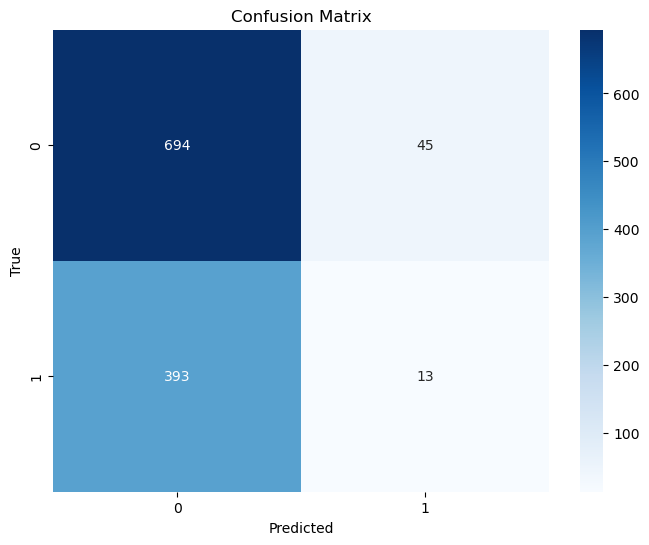

Classification Report:
               precision    recall  f1-score   support

      Benign       0.64      0.94      0.76       739
   Malignant       0.22      0.03      0.06       406

    accuracy                           0.62      1145
   macro avg       0.43      0.49      0.41      1145
weighted avg       0.49      0.62      0.51      1145



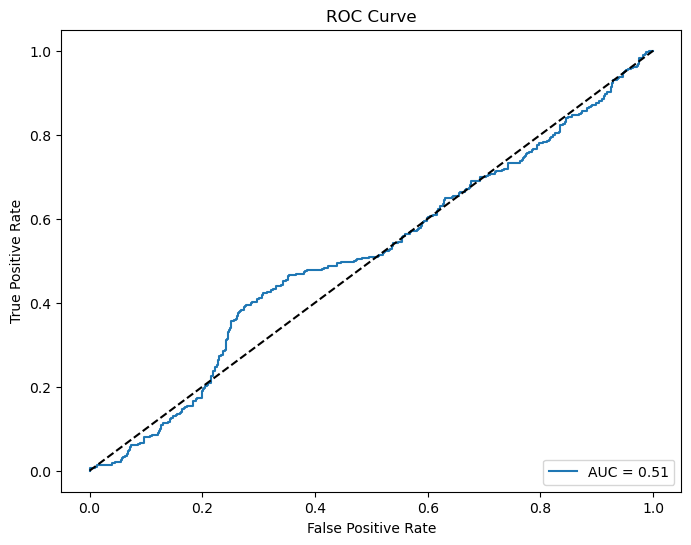

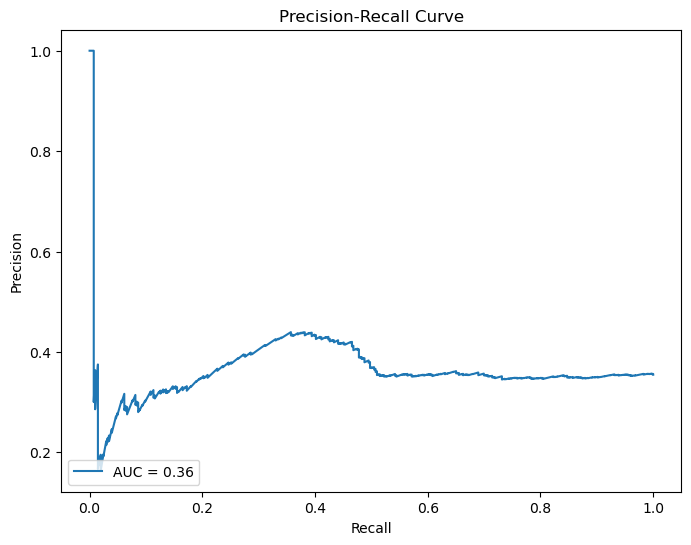

Accuracy: 61.75%
Precision: 0.22
Recall: 0.03
F1 Score: 0.06
ROC-AUC Score: 0.51


In [ ]:
# EVALUATING THE CAE

# Predict reconstructed images
X_test_pred = autoencoder.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))

# Determine the threshold for anomaly detection by setting error percentile threshold to 95
threshold = np.percentile(reconstruction_error, 95)

# using the reconstruction error for anomaly classification
y_pred = (reconstruction_error > threshold).astype(int)

# VISUALISATION OF THE EVALUATION METRICS
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_error)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


In [ ]:
# THE VARIATIONAL AUTOENCODER (VAE)

# The input for the VAE model is defined
input_image = Input(shape=(128, 128, 1))


# Building the layers of the encoder
# Using Convolutional layers (to observe features and learn patterns) with 32, 64 and 128 filters
# And pooling layers (to reduce the image dimension) to decrease the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
# the activation 'relu' introduces nonlinearity
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Flatten layer to convert the 3D output to 1D for the dense layer
x = Flatten()(x)

# the fully connected dense layer with 256 neurons and 'relu' activation for nonlinearity
x = Dense(256, activation='relu')(x)

# Dropout layer for regularisation to prevent overfitting
x = Dropout(0.4)(x)

# Defining the latent space
# size of the latent space
latent_dim = 128
# mean vector of the latent variables
z_mean = Dense(latent_dim)(x)
# log variance vector of the latent variables
z_log_var = Dense(latent_dim)(x)

# defining the sampling function to same points from the latent space for smooth and continuous learning
def sampling(latentspace_parameters):
    z_mean, z_log_var = latentspace_parameters
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # For stochasticity in sampling
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# the latent variable with lambda layer
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# Building the layers of the decoder
# Using Convolutional layers (to observe features and learn patterns) with 128, 64 and 32 filters
# And upsampling layers (to upscale image resolution) to increase the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
# the activation 'relu' introduces nonlinearity

# Input layer for the 1D vector size (the latent_dim of 128)
decoder_input = Input(shape=(latent_dim,))
# The fully connected dense layer for upscaling the latent_dim
x = Dense(16*16*128, activation='relu')(decoder_input)
# converts 1D output into 3D tensor
x = Reshape((16, 16, 128))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# final convolutional layer using a single filter to produce the output (reconstructed image)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# DEFINING THE VAE MODEL
Encoder = Model(input_image, [z_mean, z_log_var, z], name='Encoder')
Decoder = Model(decoder_input, decoded, name='Decoder')
output_image = decoder(encoder(input_image)[2])
VAE = Model(input_image, output_image, name='VAE')

# Define the combined (reconstruction and Kl divergence) VAE loss function for training the model
def vae_loss(input_image, output_image, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(K.flatten(input_image), K.flatten(output_image)) * 128 * 128
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

# Compiling the VAE model with the custom loss function (custom_vae_loss) and adam optimiser
def custom_vae_loss(y_true, y_pred):
    z_mean, z_log_var = encoder(y_true)[0], encoder(y_true)[1]
    return vae_loss(y_true, y_pred, z_mean, z_log_var)

vae.compile(optimizer=Adam(learning_rate=0.001), loss=custom_vae_loss)
vae.summary()

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Both the benign and malignant images are used in training the VAE model
history = vae.fit(datagen.flow(X_train, X_train, batch_size=32),
                  epochs=20,
                  validation_data=(X_val, X_val),
                  callbacks=[early_stopping])





Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │     8,547,328 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 1)    │     4,467,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,014,529 (49.65 MB)

 Trainable params: 13,014,529 (49.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 8810.5166 - val_loss: 6733.6860
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 6585.9468 - val_loss: 6237.7988
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - loss: 6250.5781 - val_loss: 6071.7354
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 6089.0801 - val_loss: 5999.3843
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - loss: 6012.1245 - val_loss: 5946.8662
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - loss: 5997.2246 - val_loss: 5927.9707
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 5909.8027 - val_loss: 5879.4409
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 5842.0088 - val_loss: 5872.1577
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 5858.6172 - val_loss: 5863.2090
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 5880.5967 - val_loss: 5850.8340
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 5832.6069 - val_loss: 5830.5513
Epoc

36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step


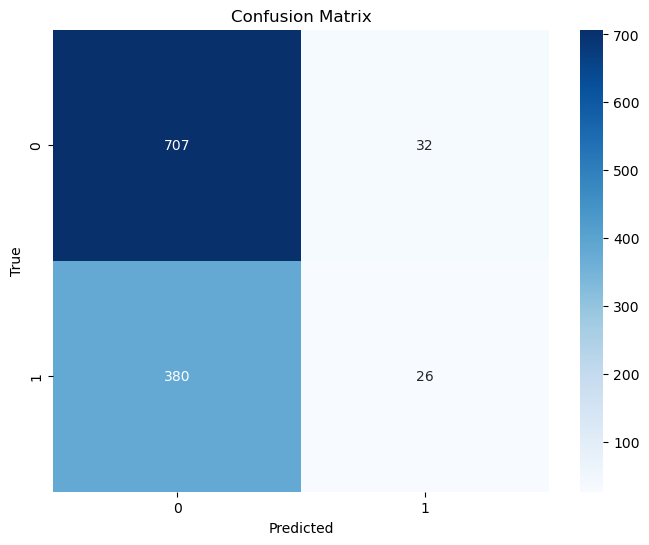

Classification Report:
               precision    recall  f1-score   support

      Benign       0.65      0.96      0.77       739
   Malignant       0.45      0.06      0.11       406

    accuracy                           0.64      1145
   macro avg       0.55      0.51      0.44      1145
weighted avg       0.58      0.64      0.54      1145



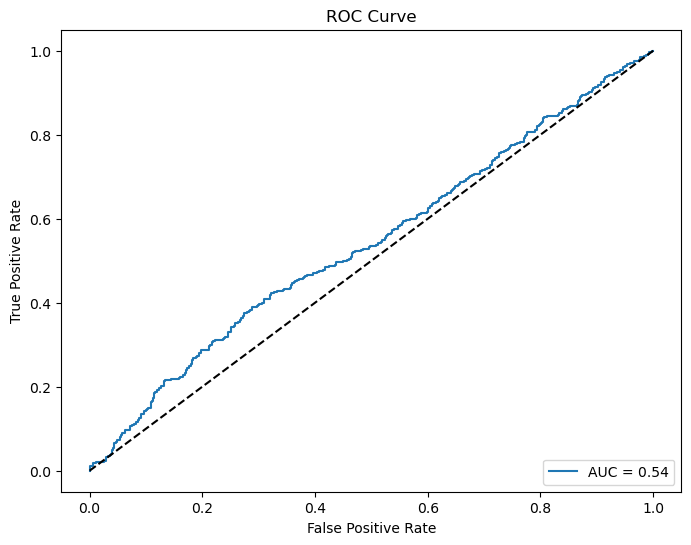

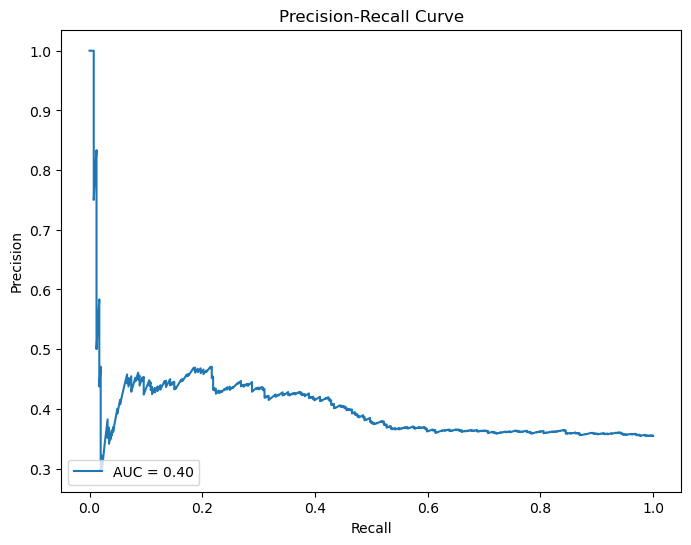

Accuracy: 64.02%
Precision: 0.45
Recall: 0.06
F1 Score: 0.11
ROC-AUC Score: 0.54


In [ ]:
# EVALUATING THE VAE

# Predict the reconstructed images
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))

# Determine the threshold for anomaly detection by setting error percentile threshold to 95
threshold = np.percentile(reconstruction_error, 95)

# using the reconstruction error for anomaly classification
y_pred = (reconstruction_error > threshold).astype(int)

# VISUALISATION OF THE EVALUATION METRICS
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_error)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


In [ ]:
# THE DENSENET MODEL

# Function to convert grayscale images to RGB (suitable for pretained models like densenet)
def convert_images(images):
    # Convert to RGB by duplicating the single channel
    images_rgb = np.repeat(images, 3, axis=-1)
    # Resizing the images to 128x128
    images_rgb_resized = tf.image.resize(images_rgb, [128, 128])
    return images_rgb_resized

# Image preprocessing to convert the dataset to rgb using the defined convert_images function
X_train_rgb = convert_images(X_train)
X_test_rgb = convert_images(X_test)

# Defining the DenseNet model

# input layer showing it is in Rgb
input_tensor = Input(shape=(128, 128, 3))
# The densenet121 architecture is used as the base model with pretrained weights from imagenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x) # reduce the dimension of the images to 1D and prevents overfitting
x = Dense(256, activation='relu')(x) # fully connected dense layer with 256 neurons
predictions = Dense(1, activation='sigmoid')(x) # single unit of output layer

# densenet model definition
model = Model(inputs=base_model.input, outputs=predictions)

# Freezing  the layers of the base model to ensure that only added layers will be updated
for layer in base_model.layers:
    layer.trainable = False

# Compiling the Densenet model using Adam optimiser
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Both the benign and malignant images are used in training the VAE model
history = model.fit(X_train_rgb, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_rgb, y_test),
                    callbacks=[early_stopping])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 65s 604ms/step - accuracy: 0.6756 - loss: 0.6863 - val_accuracy: 0.7616 - val_loss: 0.4981
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 635ms/step - accuracy: 0.7848 - loss: 0.4604 - val_accuracy: 0.8157 - val_loss: 0.4071
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 647ms/step - accuracy: 0.8635 - loss: 0.3244 - val_accuracy: 0.8568 - val_loss: 0.3282
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.8787 - loss: 0.2893 - val_accuracy: 0.8891 - val_loss: 0.2752
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 647ms/step - accuracy: 0.9300 - loss: 0.2079 - val_accuracy: 0.9179 - val_loss: 0.2226
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 652ms/step - accuracy: 0.9575 - loss: 0.1472 - val_accuracy: 0.9066 - val_loss: 0.2236
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 649ms/step - accuracy: 0.9630 - loss: 0.1353 - val_accuracy: 0.9179 - val_loss: 0.1977
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 659ms/step - accuracy: 0.9724 - loss: 0.1045 - val_accu

36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step


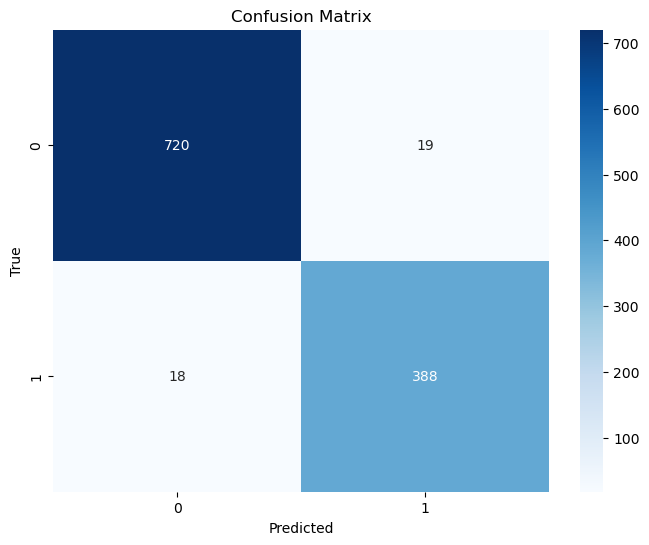

Classification Report:
               precision    recall  f1-score   support

      Benign       0.98      0.97      0.97       739
   Malignant       0.95      0.96      0.95       406

    accuracy                           0.97      1145
   macro avg       0.96      0.96      0.96      1145
weighted avg       0.97      0.97      0.97      1145



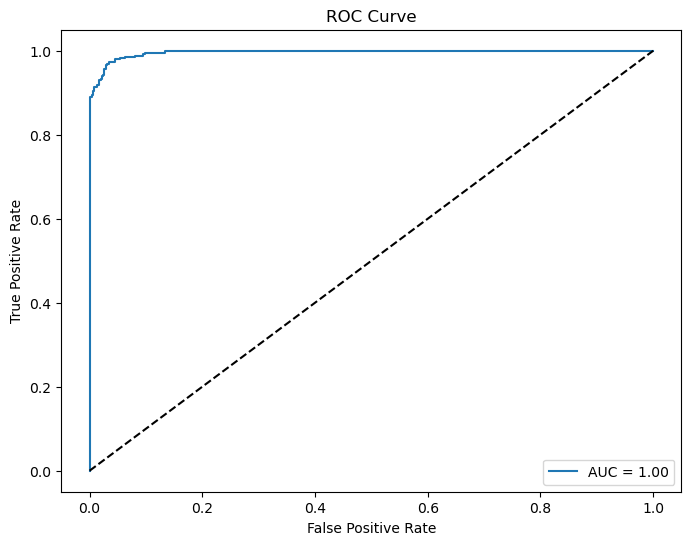

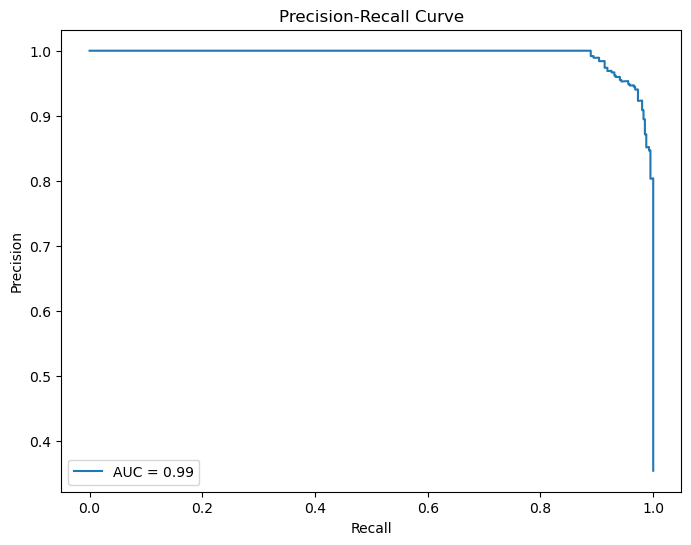

Accuracy: 96.77%
Precision: 0.95
Recall: 0.96
F1 Score: 0.95
ROC-AUC Score: 1.00


In [ ]:
# EVALUATING THE DENSENET

# Predict on test data (converted images)
y_pred_prob = model.predict(X_test_rgb)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()


# VISUALISATION OF THE EVALUATION METRICS
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision_val:.2f}")
print(f"Recall: {recall_val:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:\n", conf_matrix)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 576ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9677 - val_loss: 0.0818
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 644ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9686 - val_loss: 0.0818
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 649ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9686 - val_loss: 0.0795
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 653ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9668 - val_loss: 0.0843
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 660ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9668 - val_loss: 0.0795
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 674ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9686 - val_loss: 0.0807
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 57s 679ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9703 - val_loss: 0.0800
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accu

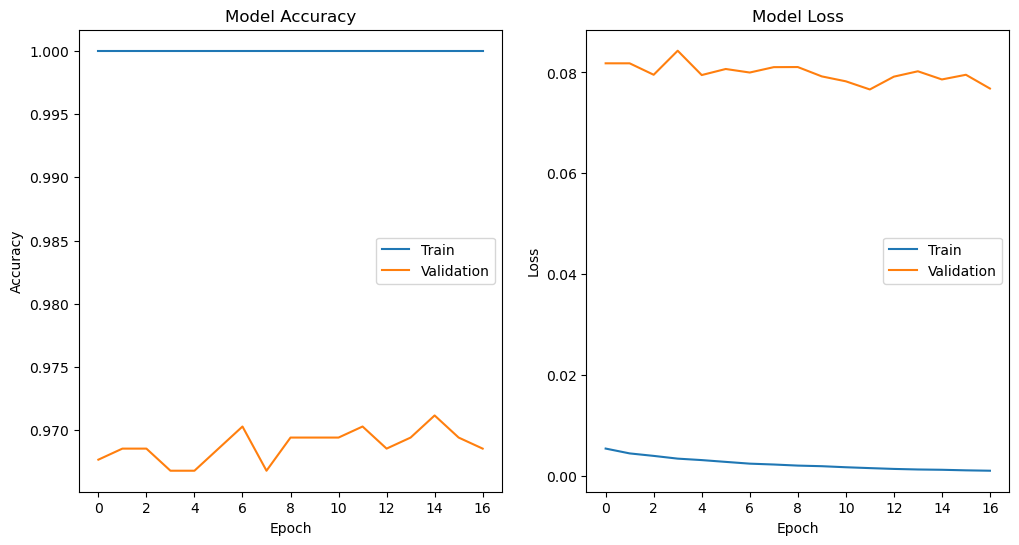

In [ ]:
# Confirming model result

# Retrieve training history
history = model.fit(X_train_rgb, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_rgb, y_test),
                    callbacks=[early_stopping])

# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [ ]:
# Ensure the data is split properly
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Verify the shapes of training and test datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (2671, 128, 128, 1)
X_test shape: (1145, 128, 128, 1)
y_train shape: (2671,)
y_test shape: (1145,)
